In [1]:
import pandas as pd 
import numpy as np 
from itertools import combinations
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_feather('data/sideview_data/1hrTRIM2024-08-29_14-01-33_SV2.tracks.feather')
data['track_id'] = [int(x) for x in data.track_id]
frame = 0
df = data[data.frame==frame].copy()

In [6]:
# Calculate Euclidean distance between all pairs of track_ids
edge_list = []
for (id1, id2) in combinations(df['track_id'].unique(), 2):
    # Get the coordinates for the two track_ids
    point1 = df[df['track_id'] == id1][['x_body', 'y_body']].values[0]
    point2 = df[df['track_id'] == id2][['x_body', 'y_body']].values[0]
    
    # Calculate the Euclidean distance
    distance = euclidean(point1, point2)
    
    # Append the result as a tuple (id1, id2, distance)
    edge_list.append((id1, id2, distance))

# Convert edge_list to a DataFrame for easy viewing
edge_df = pd.DataFrame(edge_list, columns=['track_id_1', 'track_id_2', 'distance'])

#### convert to adjacency matrix
# Get the unique track_ids
track_ids = np.unique(edge_df[['track_id_1', 'track_id_2']].values)

# Initialize the adjacency matrix with zeros
adj_matrix = pd.DataFrame(0, index=track_ids, columns=track_ids, dtype=float)

# Populate the adjacency matrix with distances
for _, row in edge_df.iterrows():
    id1 = row['track_id_1']
    id2 = row['track_id_2']
    distance = row['distance']
    adj_matrix.at[id1, id2] = distance
    adj_matrix.at[id2, id1] = distance  # Because the matrix is symmetric


     track_id_1  track_id_2     distance
0             0           1   731.140015
1             0           2   791.573303
2             0           3   908.322388
3             0           4   309.723389
4             0           5   845.529907
..          ...         ...          ...
430          26          28  1084.060181
431          26          29  1108.597412
432          27          28   101.187996
433          27          29    80.111389
434          28          29    24.715359

[435 rows x 3 columns]


[(0.0, 1800.0), (1100.0, 0.0)]

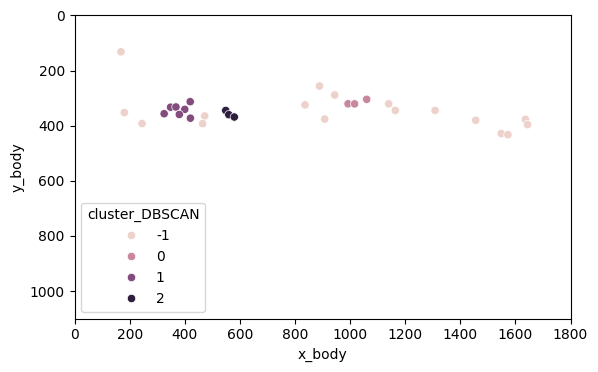

In [3]:
# cluster adj_matrix
from sklearn.cluster import DBSCAN

# DBSCAN expects a condensed distance matrix for clustering
distance_matrix = adj_matrix.values

# Perform DBSCAN clustering
# Set eps (maximum distance between two samples to be considered neighbors) and min_samples
clustering = DBSCAN(eps=48, min_samples=3, metric='precomputed')
labels = clustering.fit_predict(distance_matrix)

# Attach cluster labels back to track_ids
df['cluster_DBSCAN'] = labels

# Set the aspect ratio to be equal
fig,ax=plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')
sns.scatterplot(x=df.x_body, y=df.y_body, hue=df.cluster_DBSCAN, ax=ax)
ax.set(xlim=(0,1800), ylim=(1100,0))

In [4]:
# load frame
import cv2

# Path to your video file
video_path = 'data/sideview_data/trim.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video file was opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    # Read the first frame
    ret, frame = cap.read()
    
    if ret:
        # The frame is now stored as a variable (NumPy array)
        frame_variable = frame.astype(np.uint8)

        # cv2.imshow('Frame', frame_variable)
        # # Wait for a key press to close the window
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        
        # You can now work with frame_variable as needed
        print("Frame loaded successfully!")
        print("Frame shape:", frame_variable.shape)
    else:
        print("Error: Could not read the frame.")

# Release the video capture object
cap.release()


Frame loaded successfully!
Frame shape: (1100, 1800, 3)


Image dimensions: width=1800, height=1100
x_body range: 168.44000244140625 to 1644.0899658203125
y_body range: 131.83999633789062 to 432.4200134277344


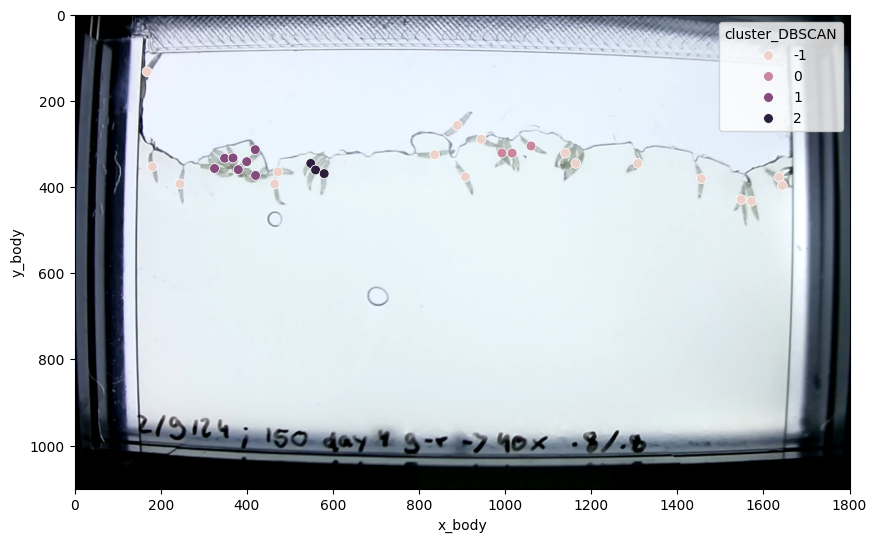

In [5]:
# Plotting the overlay
fig, ax = plt.subplots(figsize=(10, 8))

# Display the frame as the background
ax.imshow(cv2.cvtColor(frame_variable, cv2.COLOR_BGR2RGB), extent=[0, frame_variable.shape[1], frame_variable.shape[0], 0])

# Overlay the scatter plot on the image
scatter = sns.scatterplot(x=df.x_body, y=df.y_body, hue=df.cluster_DBSCAN, ax=ax, s=50)

# Set the aspect ratio to equal
ax.set_aspect('equal', adjustable='box')

# Debugging: Print the limits and adjust them dynamically
print(f"Image dimensions: width={frame_variable.shape[1]}, height={frame_variable.shape[0]}")
print(f"x_body range: {df.x_body.min()} to {df.x_body.max()}")
print(f"y_body range: {df.y_body.min()} to {df.y_body.max()}")

# Set limits based on the actual data range and image dimensions
ax.set_xlim(0, frame_variable.shape[1])
ax.set_ylim(frame_variable.shape[0], 0)  # Invert the y-axis to match image coordinates

# Show the plot
plt.show()